<a href="https://colab.research.google.com/github/AGBhartariya/Face_swap/blob/main/Face_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import cv2
import numpy as np
import dlib
import requests
from PIL import Image
from io import BytesIO

In [24]:
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

--2025-03-10 07:32:46--  https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat [following]
--2025-03-10 07:32:47--  https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.19’

shape_predictor_68_ 100%[===================>]  95.08M   397MB/s    in 0.2

In [25]:
def extract_index_nparray(nparray):
  index=None
  for num in nparray[0]:
    index=num
    break
  return index

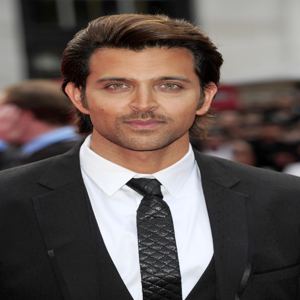

In [26]:
response=requests.get('https://www.celebritysizes.com/wp-content/uploads/2016/12/Hrithik-Roshan.jpg')
image1=Image.open(BytesIO(response.content))
image1=image1.resize((300,300))
image1

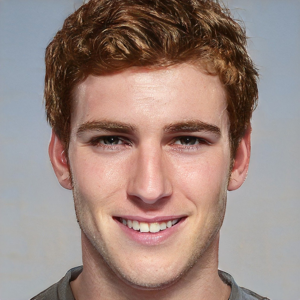

In [27]:
response=requests.get('https://cdn.pixabay.com/photo/2022/02/06/17/33/man-6997747_1280.jpg')
image2=Image.open(BytesIO(response.content))
image2=image2.resize((300,300))
image2

In [28]:
img=np.array(image1)
img_gray=cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
mask=np.zeros_like(img_gray)
img2=np.array(image2)
img_gray2=cv2.cvtColor(img2 , cv2.COLOR_BGR2GRAY)

In [29]:
detector=dlib.get_frontal_face_detector()
predictor=dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels=img2.shape
img2_new_face=np.zeros((height,width,channels),np.uint8)

In [30]:
faces=detector(img_gray)
indexes_triangles = []
for face in faces:
  landmarks=predictor(img_gray,face)
  landmarks_points= []
  for n in range(0,68):
    x=landmarks.part(n).x
    y=landmarks.part(n).y
    landmarks_points.append((x,y))

  points=np.array(landmarks_points,dtype=np.int32)
  convexhull=cv2.convexHull(points)
  cv2.fillConvexPoly(mask,convexhull,255)

  face_image_1 = cv2.bitwise_and(img, img, mask=mask)

  rect=cv2.boundingRect(convexhull)
  subdiv = cv2.Subdiv2D(rect)
  subdiv.insert(landmarks_points)
  triangles = subdiv.getTriangleList()
  triangles = np.array(triangles, dtype=np.int32)

  indexes_triangles= []
  for t in triangles:
    pt1=(t[0],t[1])
    pt2=(t[2],t[3])
    pt3=(t[4],t[5])

    index_pt1 = np.where((points==pt1).all(axis=1))
    index_pt1=extract_index_nparray(index_pt1)

    index_pt2 = np.where((points==pt2).all(axis=1))
    index_pt2=extract_index_nparray(index_pt2)

    index_pt3 = np.where((points==pt3).all(axis=1))
    index_pt3=extract_index_nparray(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
      triangle=[index_pt1,index_pt2,index_pt3]
      indexes_triangles.append(triangle)

In [31]:
#Face 2
faces2=detector(img_gray2)
for face in faces2:
  landmarks=predictor(img_gray2,face)
  landmarks_points2=[]
  for n in range(0,68):
    x=landmarks.part(n).x
    y=landmarks.part(n).y
    landmarks_points2.append((x,y))

  points2=np.array(landmarks_points2,dtype=np.int32)
  convexhull2=cv2.convexHull(points2)

  print(f"Number of detected landmarks: {len(landmarks_points2)}")
  print("Landmark points:", landmarks_points2)

Number of detected landmarks: 68
Landmark points: [(65, 140), (67, 164), (71, 187), (75, 210), (82, 232), (95, 252), (111, 269), (130, 283), (151, 288), (171, 282), (189, 268), (204, 251), (217, 232), (224, 210), (228, 187), (231, 164), (233, 141), (76, 131), (88, 121), (104, 120), (120, 123), (136, 128), (163, 128), (178, 122), (194, 120), (210, 122), (221, 132), (149, 141), (149, 158), (150, 176), (150, 194), (133, 199), (141, 203), (150, 207), (159, 203), (167, 199), (96, 142), (106, 137), (117, 138), (127, 144), (117, 144), (106, 144), (172, 144), (181, 138), (192, 138), (202, 142), (193, 144), (183, 144), (113, 218), (127, 216), (140, 216), (151, 219), (162, 216), (174, 216), (187, 217), (175, 233), (162, 242), (150, 245), (139, 243), (126, 235), (118, 220), (140, 222), (151, 223), (162, 222), (182, 219), (162, 232), (150, 234), (139, 232)]


In [32]:
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [33]:
import cv2
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)

    # Ensure 'points' is correctly defined as np.array
    points = np.array([
        [tr1_pt1[0] - x, tr1_pt1[1] - y],
        [tr1_pt2[0] - x, tr1_pt2[1] - y],
        [tr1_pt3[0] - x, tr1_pt3[1] - y]
    ], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([
        [tr2_pt1[0] - x, tr2_pt1[1] - y],
        [tr2_pt2[0] - x, tr2_pt2[1] - y],
        [tr2_pt3[0] - x, tr2_pt3[1] - y]
    ], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)  # Ensure float32 type for affine transform
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


In [34]:
img2_face_mask = np.zeros_like(img_gray2)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

In [35]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

In [36]:
print("result shape:", result.shape)
print("img2 shape:", img2.shape)
print("img2_head_mask shape:", img2_head_mask.shape)
print("Bounding box:", (x, y, w, h))
print("convexhull2 points:", convexhull2)

result shape: (300, 300, 3)
img2 shape: (300, 300, 3)
img2_head_mask shape: (300, 300)
Bounding box: (151, 223, 12, 20)
convexhull2 points: [[[233 141]]

 [[231 164]]

 [[228 187]]

 [[224 210]]

 [[217 232]]

 [[204 251]]

 [[189 268]]

 [[171 282]]

 [[151 288]]

 [[130 283]]

 [[111 269]]

 [[ 95 252]]

 [[ 82 232]]

 [[ 75 210]]

 [[ 67 164]]

 [[ 65 140]]

 [[ 88 121]]

 [[104 120]]

 [[194 120]]

 [[210 122]]]


In [37]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

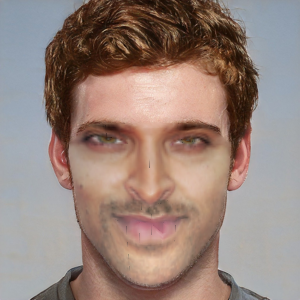

In [38]:
# Converting array to image
Image.fromarray(seamlessclone)